# <span style="color: royalblue;">Introduction to Unsupervised Learning - Final Project</span>

<span style="font-size: 18px; font-weight: bold; color: royalblue;">Latent Product Grouping and Association Rule Mining on Grocery Transactions</span>

<span style="font-size: 13px; font-weight: bold; color: royalblue;">Author: David Weber, 2025 Spring 2 Session</span>

<span style="font-size: 14px; font-weight: bold; color: royalblue;">Introduction:</span>

When I first started getting interested in artifical intelligence years ago, I heard about retail stores using the shopper's transaction data to group products together in the store that were bought together. I thought that was an interesting use of machine learning, but I didn't know how that was done. After this class, I now know that was an unsupervised learning technique. In this project, I would like to implement those techniques.

To formally state what this project is about, I am going to analyze grocery transaction data with two complementaty unsupervised learning techniques to uncover meaningful product paterns. One method will be a technique we learned in class, **Non-negative Matrix Factorization (NMF)** to identify latent product groupings, which will reveal hidden structure in shopper's purchasing habits. The other method will be new, **association rule mining** using the **Apriori** algrorithm to find items that are frequently purchased together. These two approaches can provide insights into product categories and practical retail product placement ideas.

<span style="font-size: 14px; font-weight: bold; color: royalblue;">Dataset:</span>

Kartheek, B. (2022). Groceries Dataset. Kaggle. Retrieved March 18, 2025, from https://www.kaggle.com/datasets/balajikartheek/groceries-dataset

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Setup:</span>

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import display, HTML
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from abc import ABC, abstractmethod
from mlxtend.frequent_patterns import apriori, association_rules

%matplotlib inline

In [2]:
SEED_VALUE = 100
TITLE_FONT_SIZE = 14
DISPLAY_FONT_SIZE = 14

# Set the seed
np.random.seed(SEED_VALUE)

# Remove restrictions on column width display:
pd.set_option('display.max.colwidth', None)

# Remove restrictions on number of rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Custom function for key, value pair display
def custom_display(title, value=None):
    """
    Prints output with larger font and bold title.
    """
    display(HTML(f'<span style="font-size:{DISPLAY_FONT_SIZE}px;"><b>{title}</b>{f": {value}" if value is not None else ""}</span>'))

# Customizing dataframe table display with larger font.
display(HTML(f"<style>table.dataframe th, table.dataframe td {{font-size: {DISPLAY_FONT_SIZE}px;}}</style>"))

# Custom display of a data from table and title:
class DataFrameDisplayManager:
    """
    Used to display a single dataframe with a title.
    """
    def __init__(self):
        pass
    def display(self, df, title, color):
        display(HTML(f"""
            <div style="display: grid; grid-template-columns: repeat(1, 1fr); grid-template-rows: repeat(2, 0.1fr); gap: 10px;">
                <div style="text-align: center; font-size: {TITLE_FONT_SIZE*1.2}px; font-weight: bold;">{title}</div>
                <div style="display: flex; justify-content: center; background-color: {color};">{df.round(2).to_html(index=False)}</div>
            </div>
        """))
        
df_manager = DataFrameDisplayManager()

## <span style="color: royalblue;">A Quick Look at the Data</span>

Before I get into the actual **EDA** portion of this project, I will get a quick look at the data. This won't be an exhaustive analysis, just some information to use to guide the **EDA and Data Cleanup** process.

In [3]:
# Data directory is at the same level as this notebook file.
grocery_df = pd.read_csv(os.path.join('data', 'archive', 'Groceries_dataset.csv'))

In [4]:
df_manager.display(grocery_df.head(8), 'Grocery Data:', 'lightblue')
custom_display('Grocery Data Info')
print(grocery_df.info())
custom_display('Grocery Data Shape', grocery_df.shape)
custom_display('Unique Member_number count', grocery_df['Member_number'].nunique())
custom_display('Unique Date count', grocery_df['Date'].nunique())
custom_display('Unique itemDescription count', grocery_df['itemDescription'].nunique())

Member_number,Date,itemDescription
1808,21-07-2015,tropical fruit
2552,05-01-2015,whole milk
2300,19-09-2015,pip fruit
1187,12-12-2015,other vegetables
3037,01-02-2015,whole milk
4941,14-02-2015,rolls/buns
4501,08-05-2015,other vegetables
3803,23-12-2015,pot plants


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB
None


<span style="font-size: 17px; font-weight: bold; color: royalblue;">Observations:</span>
* There are no missing values. We can see that because the reported number of non-null rows for each column match the first element of the shape.
* The dataset is a decent size for an unsupervised training problem (38,765 rows).
* The **Member_number** column is type **int64**
* The **Date** and **itemDescription** columns are type **object**. I'll look at converting these in the **EDA and Data Cleanup** section.
* From the few rows that were printed out we can see that these are relatively generic product descriptions.
* The memory usage is low.
* There are 3898 unique customers shopping over 728 days for a total of 167 grocery items.
* True to unsupervised learning, this dataset is completely unlabeled.

This dataset is good for this task, as I am mostly interested in the application of the various techniques. Also, true to unsupervised learning, this dataset is completely unlabeled.

I will now examine the data more closely in the **EDA and Data Cleaning** section.

## <span style="color: royalblue;">Exploratory Data Analysis (EDA) and Data Cleaning</span>

Above we took a quick look at the dataset to see what we are dealing with. We learned a number of things that will be useful in this EDA section.

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Renaming columns:</span>

The first thing I want to do is rename the columns. I want to change **Member_number** to **customer_id**, **Date** to **date**, and **itemDescription** to **item**. I want to simplify the handling of the data, and this will be one way to do it.

In [5]:
grocery_df.rename(columns={'Member_number': 'customer_id', 'Date':'date', 'itemDescription': 'item'}, inplace=True)
custom_display('New column names', grocery_df.columns)

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Changing data types:</span>

In the initial look at the data, we saw that both the **date** and the **item** columns are type **object**. I want to change the **date** column to a **date** type and the **item** column (that has text data) to **StringDtype**. Pandas recommends that text data be stored as that type.

In [6]:
grocery_df['date'] = pd.to_datetime(grocery_df['date'], format='%d-%m-%Y').dt.date
grocery_df['item'] = grocery_df['item'].astype(pd.StringDtype())

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Checking for missing values:</span>

In [7]:
print(grocery_df.isnull().sum())

customer_id    0
date           0
item           0
dtype: int64


<span style="font-size: 17px; font-weight: bold; color: royalblue;">Duplicate check:</span>

In [8]:
duplicate_count = grocery_df.duplicated(subset=['customer_id', 'date', 'item']).sum()
custom_display("Duplicate entry count", duplicate_count)

There are 759 duplicates. There are three possibilities that I can think of for this. The first is this represents multiple items being purchased. The second is that the same customer bought the exact same thing multiple times on the same day. The third is this is a mistake in the dataset. Regardless of the reason, for this project I don't want the duplicate rows, so I will remove them.

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Removing duplicates:</span>

In [9]:
# Removing duplicates and keeping the first occurence of each
grocery_df = grocery_df.drop_duplicates(subset=['customer_id', 'date', 'item'], keep='first')

# Verifying the duplicates were removed
duplicate_count = grocery_df.duplicated(subset=['customer_id', 'date', 'item']).sum()
custom_display("Duplicate entry count", duplicate_count)

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Text Consistency:</span>
I will make sure all the items listed are in lowercase.

In [10]:
grocery_df['item'] = grocery_df['item'].str.strip().str.lower()

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Word-Frequency Histogram</span>

Using a word-frequency histogram we can see the most dominant item being purchased.

From a previous assignment in this class, I used the TfidfVectorizer. It's ability to identify the most meaningful words works well with a word-frequency histogram so I will use it here for that.

In [11]:
class ItemVectorizerManager:
    """
    Creates a TF_IDF Vectorizer and fits it to the item df series.
    """
    def __init__(self, grocery_df):
        self.items = grocery_df['item']
        self.max_features = grocery_df['item'].nunique()

    def create_vectorizer(self):
        vectorizer = TfidfVectorizer(max_features=self.max_features)
        document_term_matrix = vectorizer.fit_transform(self.items)

        return vectorizer, document_term_matrix
        

In [12]:
class WordFrequencyHistogramManager:
    def __init__(self, vectorizer, document_term_matrix):
        self.vectorizer = vectorizer
        self.document_term_matrix = document_term_matrix

    def __create_word_frequency_df(self):
        word_frequency_df = pd.DataFrame({'Items': self.vectorizer.get_feature_names_out(), 'Frequency': self.document_term_matrix.sum(axis=0).A1})
        return word_frequency_df.sort_values(by='Frequency', ascending=False)
        
    def display_histogram(self, num_words, bar_color='blue'):
        word_frequency_df = self.__create_word_frequency_df()

        plt.figure(figsize=(25,7))
        plt.bar(word_frequency_df['Items'][:num_words], word_frequency_df['Frequency'][:num_words], color=bar_color)
        plt.xticks(rotation=75)
        plt.xlabel("Items")
        plt.ylabel("Frequency")
        plt.title(f"Top {num_words} Items")

        plt.show()

Because of space limitations, I will limit the word-frequency histogram to the top 50 words. This should be enough information to uncover any trends or spot any issues.

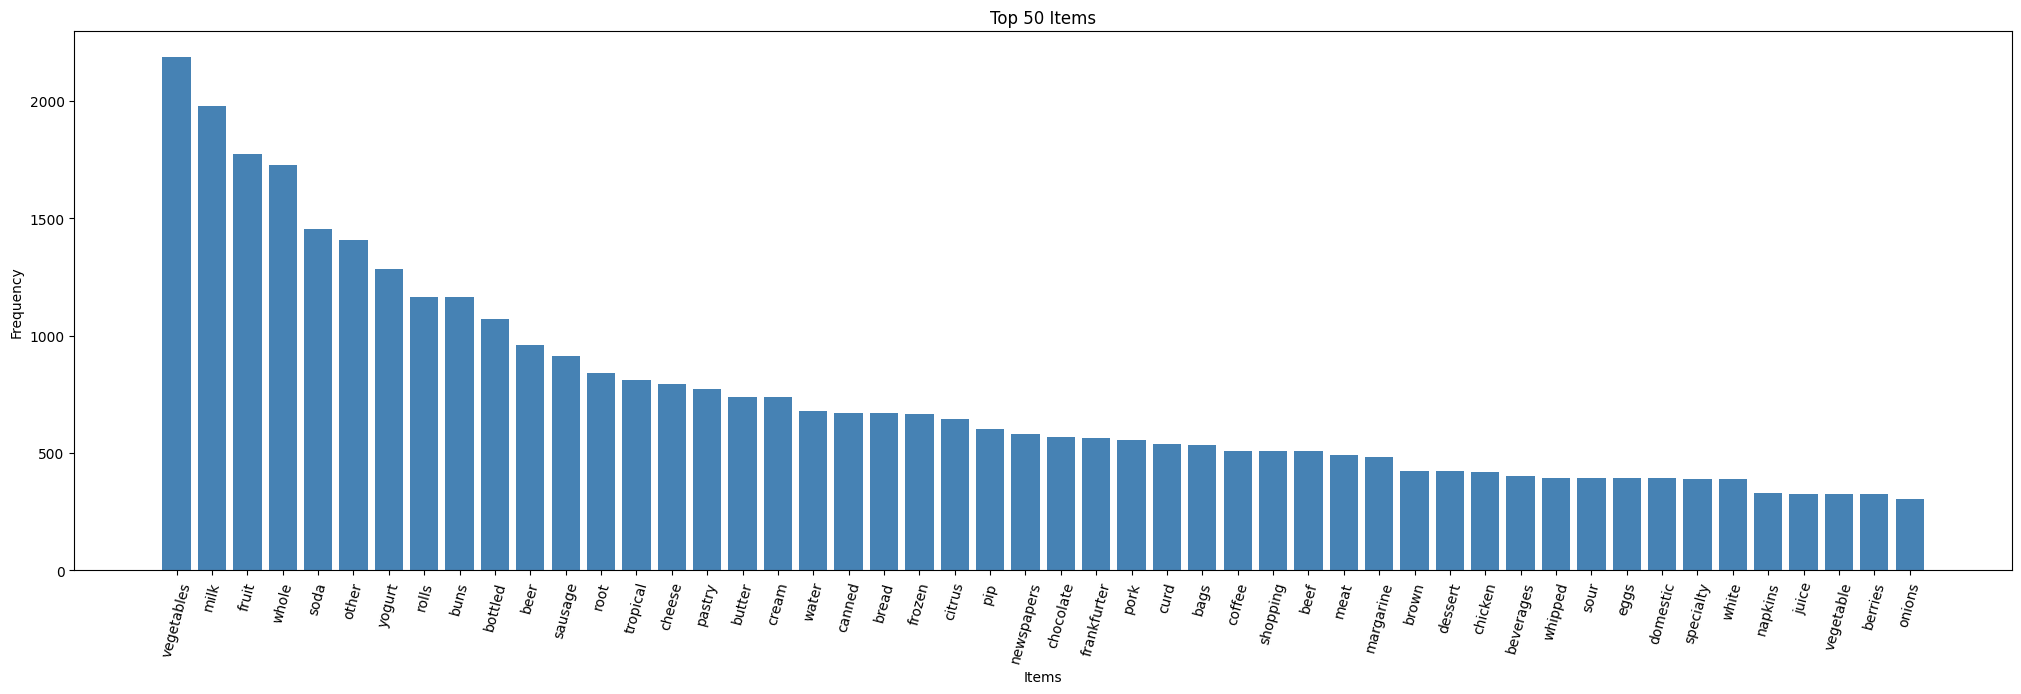

In [13]:
# Create the vectorizer and document term matrix
item_vectorizer_manager = ItemVectorizerManager(grocery_df)
vectorizer, document_term_matrix = item_vectorizer_manager.create_vectorizer()

num_words_to_include = 50
# Display the histogram
word_frequency_histogram_manager = WordFrequencyHistogramManager(vectorizer, document_term_matrix)
word_frequency_histogram_manager.display_histogram(num_words_to_include, bar_color='steelblue')

I'm seeing an issue here. It's turning bigrams into unigrams so that items like "whole milk" are becoming separate items. Another issue is that items like "rolls/buns" are also being treated as two words. To fix this we could set the ngram range in the Vectorizer constructor, but that could lead to other issues. 

I think it's best in this case to update the data and join any multi-work items with '_':

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Updating Items</span>

In [14]:
grocery_df['item'] = grocery_df['item'].str.replace(' ', '_').str.replace('/', '_').str.replace('-', '_')

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Word-Frequency Histogram After Update</span>

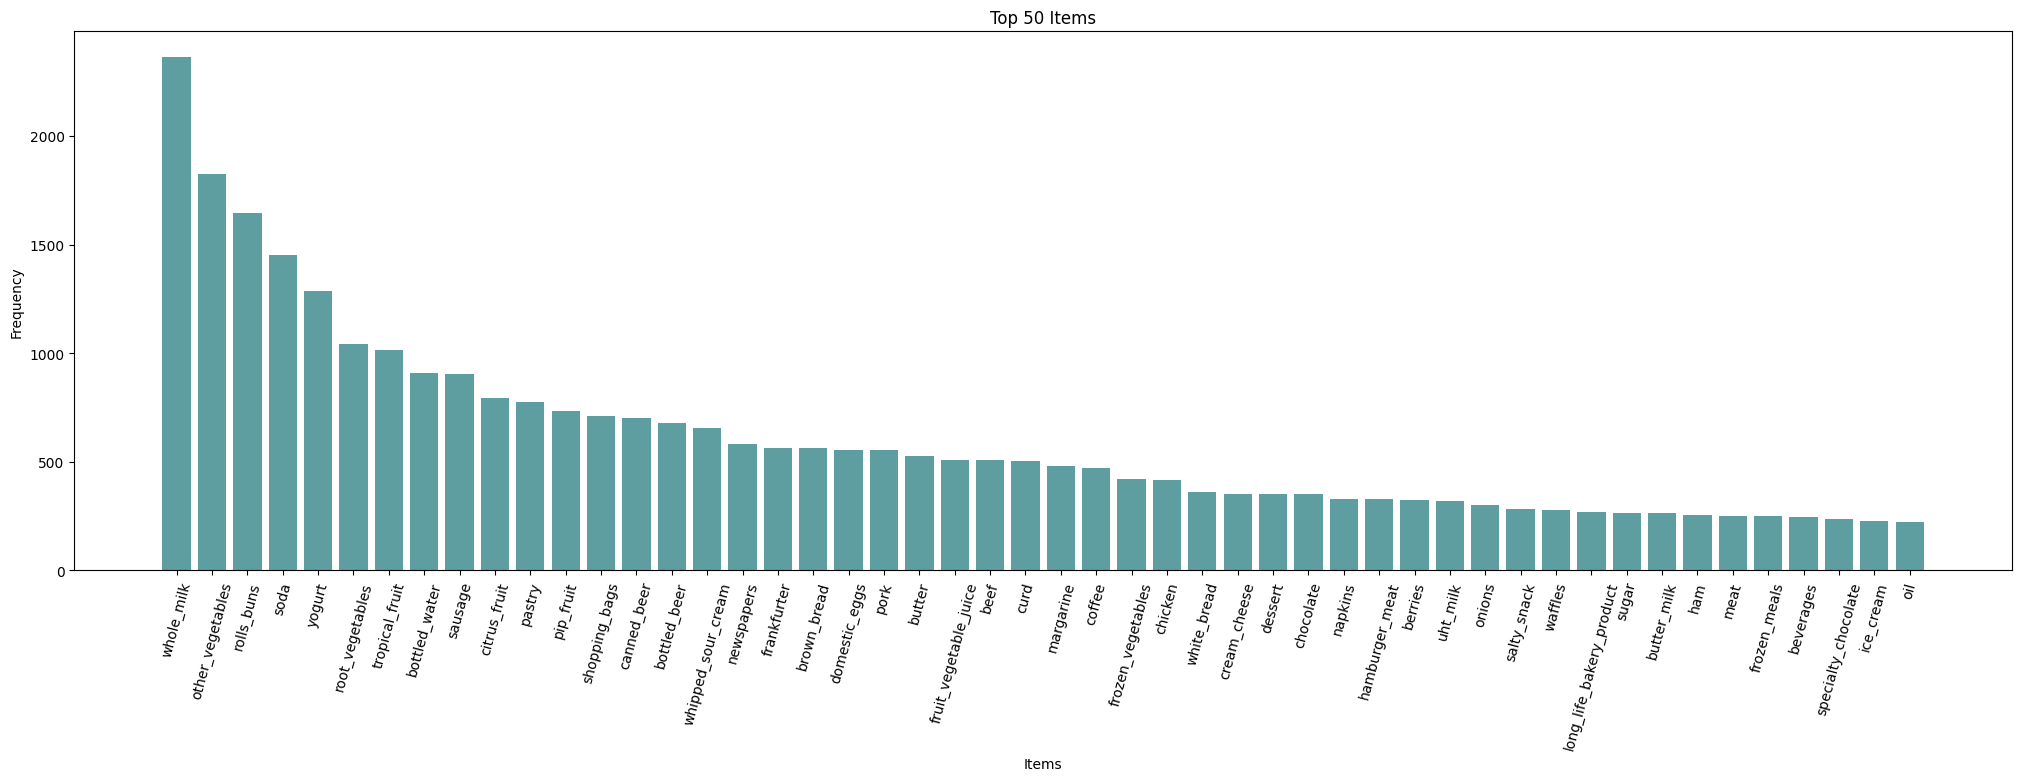

In [15]:
# Create the vectorizer and document term matrix
item_vectorizer_manager = ItemVectorizerManager(grocery_df)
vectorizer, document_term_matrix = item_vectorizer_manager.create_vectorizer()

# Display the histogram
word_frequency_histogram_manager = WordFrequencyHistogramManager(vectorizer, document_term_matrix)
word_frequency_histogram_manager.display_histogram(num_words_to_include, bar_color='cadetblue')

That is a big difference! It went from 'vegetables' at the top to 'whole milk' being at the top.

This is important for another reason. Later I will be using the non-negative matrix factorization (NMF) and it could have issues splitting on spaces.

Other good news, people seem to still be buying lots of vegetables! :-)

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Word Cloud</span>

A intuitive way to visualize dominant words is to use a word cloud. This will help us see which items might be dominant in the dataset. This is also a good approach since using the histogram, we had to limit the words that were shown because of space limits.

In [16]:
class WordCloudManager:
    """
    Manages the displaying of the word clouds
    """
    def __init__(self, grocery_df):
        self.grocery_df = grocery_df

    def display(self):
        width = 850
        height = 400
        word_cloud = WordCloud(width=width, height=height, background_color='white', random_state=SEED_VALUE).generate(" ".join(self.grocery_df['item']))

        _, ax = plt.subplots(figsize=(13, 7))
        ax.imshow(np.asarray(word_cloud), interpolation='bilinear')
        ax.axis('off')

        # Center the image
        # ax.set_xlim(-0.03 * width, width)
        
        plt.title('Item Word Cloud', fontsize=TITLE_FONT_SIZE, fontweight='bold')
        plt.show()

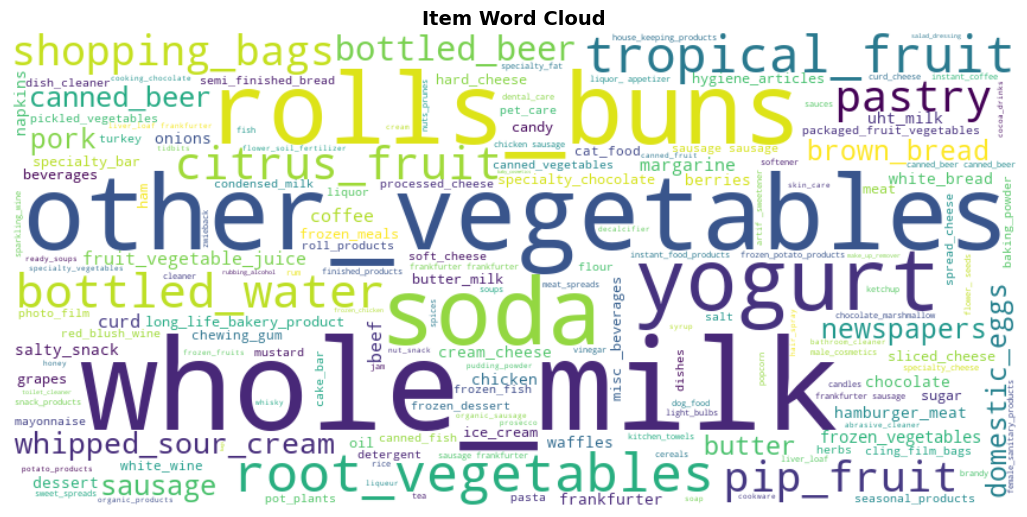

In [17]:
word_cloud_manager = WordCloudManager(grocery_df)
word_cloud_manager.display()

From this word cloud we can easily see the most dominant words. Whole milk, other vegetable, rolls/buns, yogurt, and soda stick out immediately.

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Co-occurrence Heatmap</span>

Now I will use a heatmap to see how often products are bought together. This will give us some sense as to how the NMF might group products into categories (or topics as it's typically called with NMF).

In [18]:
class HeatmapCorrelationManager:
    """
    Manage the display of the heatmap for a co-occurance of items
    """
    def __init__(self, grocery_df, num_top_items, title):
        self.correlation_matrix = self.__create_correlation_matrix(grocery_df, num_top_items)
        self.title = title
        
    def __create_correlation_matrix(self, grocery_df, num_items):
        # Create a "basket" that ties the customer_id and date to an item
        baskets = grocery_df.groupby(['customer_id', 'date'])['item'].apply(list)

        # A heatmap with all products would be too cluttered, so i will limit it to the top N most purchased products
        top_products = grocery_df['item'].value_counts().head(num_items).index

        # Filter the basket to only include top product items
        filtered_baskets = baskets.apply(lambda items: [item for item in items if item in top_products])

        # Create a matrix that is shaped (n x n) where n is the number of top products
        summary_matrix = pd.DataFrame(0, index=top_products, columns=top_products)
        
        # Incremment based on occurances of each item
        for items in filtered_baskets:
            for i in range(len(items)):
                for j in range(i+1, len(items)):
                    summary_matrix.loc[items[i], items[j]] += 1
                    summary_matrix.loc[items[j], items[i]] += 1

        # From the documentation: "The Spearman rank-order correlation coefficient is a nonparametric measure of the monotonicity 
        # of the relationship between two datasets."
        return summary_matrix.corr(method='spearman')
        
    def display(self):
        plt.figure(figsize=(17,15))
        plt.title(self.title, fontsize=TITLE_FONT_SIZE, fontweight='bold')
        sns.heatmap(self.correlation_matrix, cmap='Blues', annot=True, linewidths=0.5)
        plt.xlabel("Items")
        plt.ylabel("Items")
        plt.show()                              

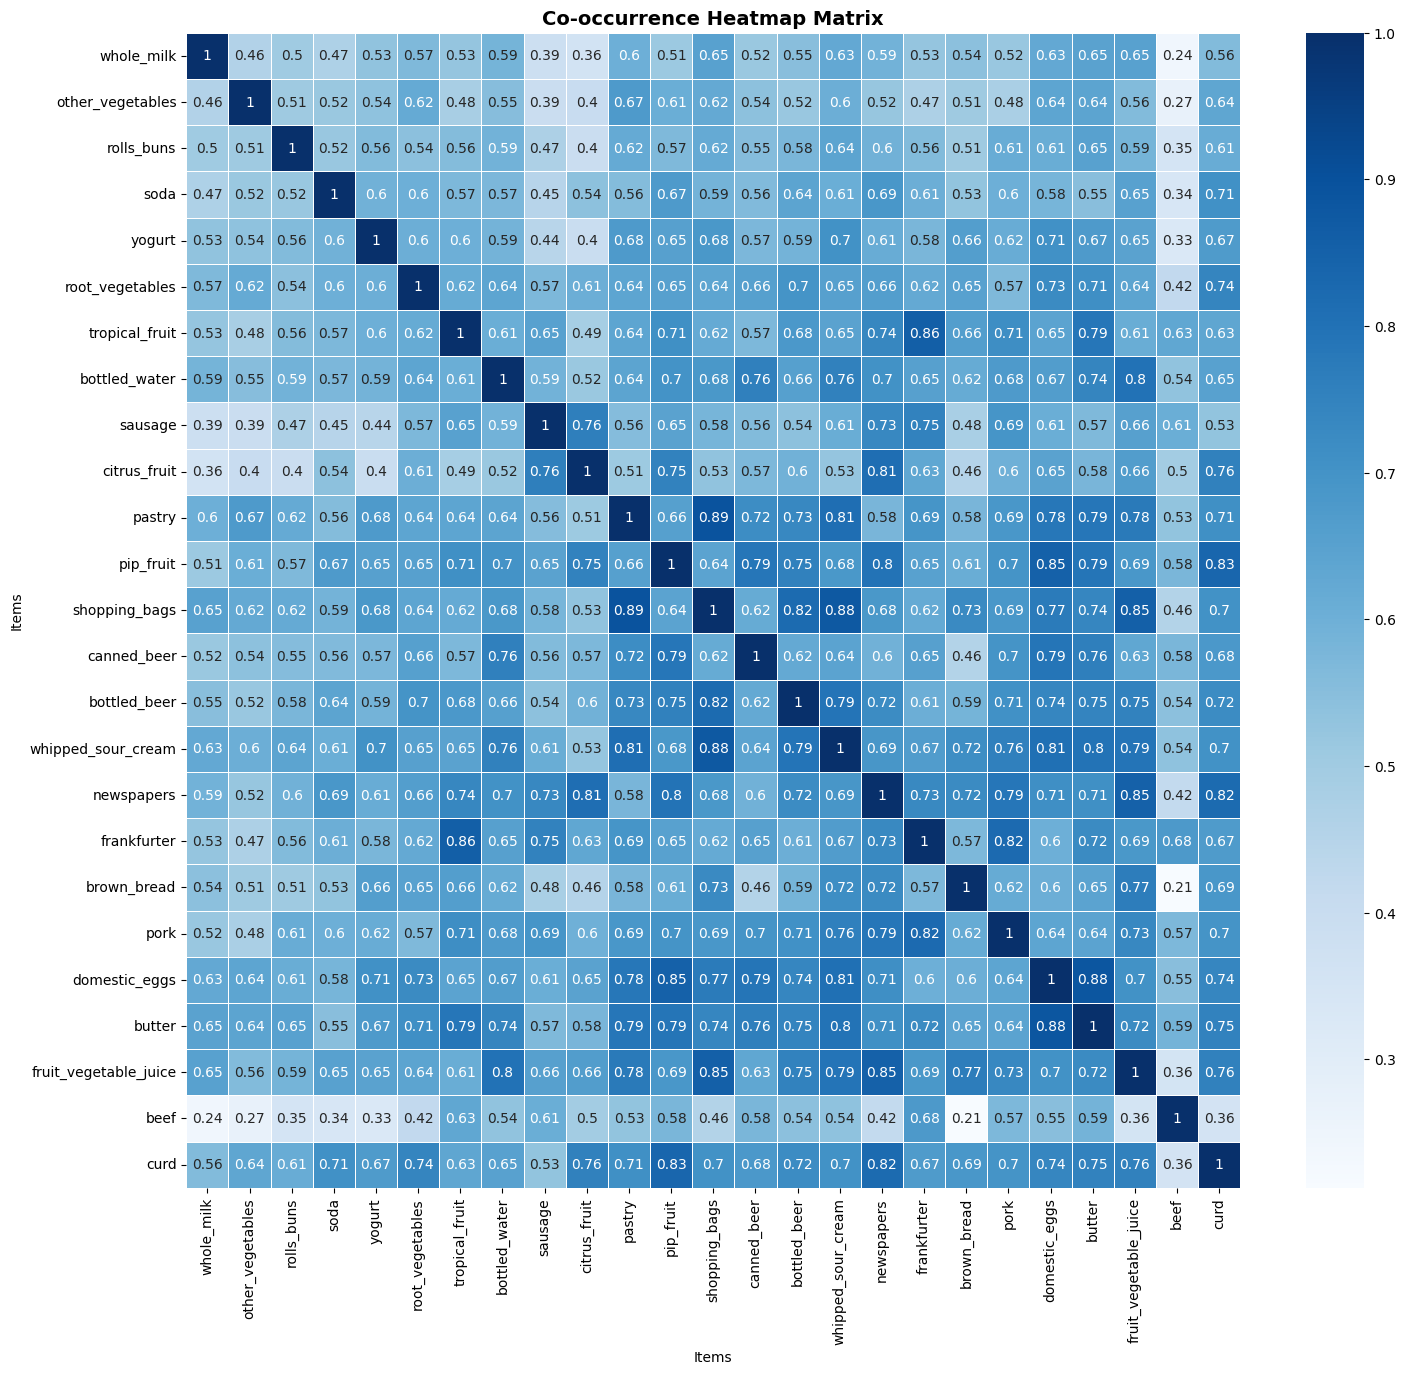

In [19]:
heatmap_correlation_manager = HeatmapCorrelationManager(grocery_df, 25, "Co-occurrence Heatmap Matrix")
heatmap_correlation_manager.display()

Some of these make sense, like "pip fruit" and "citrus fruit" occurring together. Others might be harder to see why they would be bought together. But anyone that does grocery shopping can tell you that's often how it goes. The goal of this project isn't to match up items that should belong together, rather a way for retailers to organize their store layout to better serve the customers and possibly increase sales. With that note, I think this heatmap does make sense.

<span style="font-size: 17px; font-weight: bold; color: royalblue;">EDA and Data Cleaning Summary and Discussion</span>

* I renamed all the columns in the grocery_df to be easier to work with and a couple columns (customer_id and item) being more concise.
* I changed the data type of the date field to be of type date and the item field to be of type StringDtype (which is recommended by Pandas).
* A duplicate check was done and several were found. In the discussion above I mentioned that the reason for the duplicates (intentional or mistake) was not important as for this task it doesn't make sense to have duplicates as it could interfere with the later model training and analysis.
* The item text was made to be consistent (e.g. all lowercase, trimming text).
* A word-frequency histogram was done to discover the most frequent words. In doing this, it was discovered that the items with more than one word were being split apart. This could cause problems later with the model training and analysis, so I fixed that issue by replacing characters that could be used to split words with the underscore character.
* A word cloud was created from all the items. Because a word cloud doesn't suffer from being too crowded like the word-frequency can, all items were included. This helped visualize the dominant items in the dataset.
* A co-occurrence matrix heatmap was created to visualize which items might be purchased together. While some made obvious sense, others did not have a readily apparent correlation.

With the exploratory data analysis, a number of issues with the data were discovered and corrected, The various analytics gave us a glimpse at how the data is structured and correlated. From this section (and the prior "A Quick Look at the Data" section), I am ready to use what I have learned to construct the models.

## <span style="color: royalblue;">Latent Product Groupings</span>

From the introduction I mentioned that for this project one of the unsupervised learning techniques I will use will be using non-negative matrix factorization (NMF) to uncover latent product groupings. From the co-occurrence heatmap plot it we began to see how some items might be purchased together, but it's not often only two items are purchases at a time. Using a NMF technique, we can discover multiple products that might be purchased together which can aid retailers in layout out the stores for efficiency and increased sales.

<span style="font-size: 17px; font-weight: bold; color: royalblue;">NMF Overview</span>

In the below diagram, matrix **V** (size m x n) is decomposed into two lower-dimensional matrices **W** (size m x k) and **H** (size k x n). Here **m** is the number of *transactions* (customer_id and date), **n** is the number of *products*, and **k** will be the number of *latent* factors. One of the hyperparameters here is picking the value of **k**. Matrices **W** and **H** then approximate our original matrix **V**.

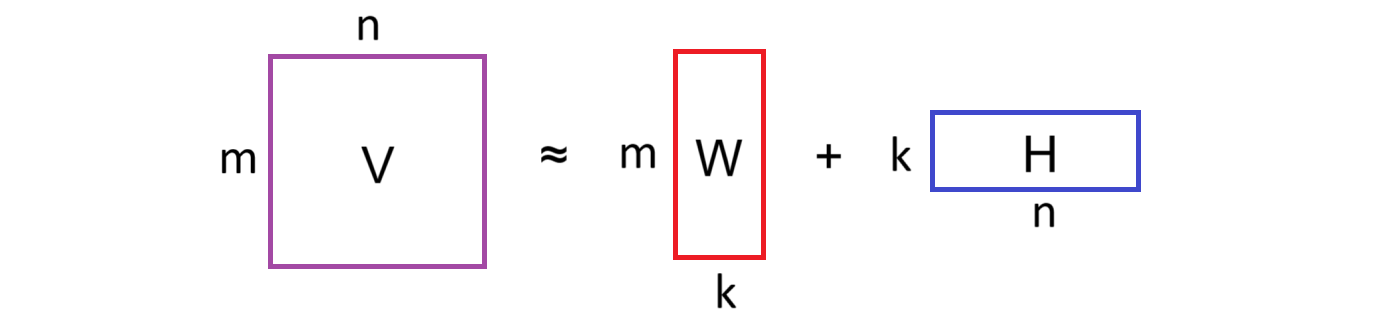

For NMF to be used, the matrices must be non-negative. With out dataset here, that requirement is met. There will be zero or more products at all times in each of the transactions.

By using NMF we will find the latent product patterns, that is, find product groupings that are not explicitly observed but inferred through patterns in the data. Learning patterns in data is something unsupervised learning can be particularly good at.

<span style="font-size: 17px; font-weight: bold; color: royalblue;">NMF Model Building</span>

I will be using Scikit-learn's NMF implementation for this portion of the project. This NMF library will aid in finding the two non-negative matrices (W and H in the above diagram) whose product will approximate the matrix V (also non-negative).

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Baseline NMF Model</span>

For this first step, other than the number of components (**k** as discussed above) and the number of iterations*, I will be sticking with the default values for the constructor arguments. 

<span style="font-size: 14px; font-weight: bold; color: royalblue;">Hyperparameter Tuning Highlights</span>

As mentioned above, for this first iteration, the values (other than n_components) will be set to the default values and I will explicitly set them here for reference. (These settings are in context to the 1.6.1 sci-kit learn documentation).

* I will be using the default **nndsvda** init method. In the documentation it states that **nndsvda** is used if **None** is selected (provided n_components meets the certain criteria - which it is in my case). I will explicitly set it however.
* Solver will be set to the default **Coordinate Descent** (cd).
* beta loss will be set to th default **frobenius**. This is the beta divergence to be minimized by measuring the distance between **V** and the dot product between **W** and **H**.
* tol will be set to 1e-4. This is the stopping condition.
* The default maximum number of iterations is 200. I will increase this to 300 in order to avoid warnings of no convergence.
* alpha_W will be set to 0.0 (No regularization on W).
* alpha_H will be set to 0.0 (No regularization on H).
* l1_ratio will be set to 0.0. (This is the regularization mixing parameter).
* shuffle will be set to False (No randomization on the default CD solver).

*I'm increasing the number of iterations because for low values of **k**, NMF has a tendency to not converge.

In [20]:
class DataCreator:
    """
    Creates the data matrix needed for the NMF and Apriori models.
    """
    def __init__(self, grocery_df):
        self.grocery_df = grocery_df

    def create_one_hot_matrix(self):
        """
        Creates a one-hot encoded matrix with the shape "basket" x items
        """
        # Get the unique list of items
        all_items = sorted(self.grocery_df['item'].unique())
        # Creating a dictionary to map item to index
        
        item_index_map = {item: i for i, item in enumerate(all_items)}
        
        # Create the baskets (These are the items bought together by the same customer at the same date)
        baskets = self.grocery_df.groupby(['customer_id', 'date'])['item'].apply(list)

        # Create the empty one-hot matrix
        matrix = np.zeros((len(baskets), len(all_items)), dtype=int)

        #Iterate through all the baskets
        for i, items in enumerate(baskets):
            for item in items:
                # Locate the column
                j = item_index_map[item]
                matrix[i, j] = 1

        # Convert to a Pandas dataframe for easier use later
        return pd.DataFrame(matrix, columns=all_items, index=baskets.index)

In [21]:
class AbstractNMFManager(ABC):
    """
    Abstract class to handle any variation of the NMF model.
    """
    def __init__(self, grocery_df):
        self.data_creator = DataCreator(grocery_df)

        self.V = None
        self.W = None
        self.H = None
        self.model = None
        
    @abstractmethod
    def build_nmf_model(self, num_product_groupings):
        # Override in subclass
        pass

    def __reset(self):
        self.V = None
        self.W = None
        self.H = None
        self.model = None
    
    def fit_transform(self, num_product_groupings):
        self.__reset()
        
        self.model = self.build_nmf_model(num_product_groupings)

        self.V = self.data_creator.create_one_hot_matrix()

        self.W = self.model.fit_transform(self.V.to_numpy())
        self.H = self.model.components_

In [22]:
class BaselineNMFModelManager(AbstractNMFManager):
    """
    Initial NMF model
    """
    def __init__(self, grocery_df):
        super().__init__(grocery_df)

    # Override
    def build_nmf_model(self, num_product_groupings):
        model = NMF(n_components=num_product_groupings,
                    init='nndsvda',
                    solver='cd',
                    beta_loss='frobenius',
                    tol=1e-4,
                    max_iter=300,
                    random_state=SEED_VALUE,
                    alpha_W=0.0,
                    alpha_H=0.0,
                    l1_ratio=0.0,
                    shuffle=False)
        return model

We want to find the ideal number of product groupings to express the latent grouping information. One way to do this is to try different values of **k** that minimize the error, but stop when the error is minimized. To do that, I will create a **ProductGroupingIterationManager** that will iterate through values of **k** and stop when an error threshold is met (or we reach max allowed iterations).

In [23]:
class EarlyStoppingController:
    """
    Based on a threshold value, this controller will decide when the number of groupings has reached a point where the reconstruction
    error is not improving significantly.
    """
    def __init__(self, error_threshold):
        self.error_threshold = error_threshold
        self.previous_error = None

    def reset(self):
        self.previous_error = None
        
    def should_stop(self, error):
        # Not using absolute value here as we only want to measure improvement in one direction.
        if self.previous_error and (self.previous_error - error) < self.error_threshold:
            return True
            
        self.previous_error = error
        return False

In [24]:
class BestModelValues:
    """
    Container for the best values obtained with the ProductGroupingIterationController.
    """
    def __init__(self, model, V, H, W):
        self.model = model
        self.V = V
        self.H = H
        self.W = W

In [25]:
class ProductGroupingIterationController:
    """
    Controller to find the ideal number of product groupings based on reconstruction error.
    """
    def __init__(self, model_manager, max_iterations, early_stopping_controller):
        self.model_manager = model_manager
        self.max_iterations = max_iterations
        self.early_stopping_controller = early_stopping_controller
        self.best_model_values = None
        self.k_value_list = []
        self.reconstruction_error_list = []

        self.early_stopping_controller.reset()
        
    def fit(self):
        # Testing out every number of product groupings from 1 to max_iterations
        for i, num_groupings in enumerate(range(1, self.max_iterations + 2), start=1):
            self.model_manager.fit_transform(num_groupings)

            self.reconstruction_error_list.append((num_groupings, self.model_manager.model.reconstruction_err_))
            
            if i == 1 or i % 10 == 0:
                print(f"Iteration: {i}, reconstruction error: {self.reconstruction_error_list[-1][1]}")

            # Check if we have reached a threshold to stop
            if self.early_stopping_controller.should_stop(self.reconstruction_error_list[-1][1]):
                break
            else:
                # Keep this model and it's values as we are still making significant progress.
                self.best_model_values = BestModelValues(self.model_manager.model, 
                                                       self.model_manager.V, 
                                                       self.model_manager.H, 
                                                       self.model_manager.W)

In [26]:
# Set the early stopping threshold
early_stopping_controller = EarlyStoppingController(0.025)
# Set the maximim number of iterations (which coincides with the number of product groupings).
num_iterations = 100

# Create the NMF model
model_manager = BaselineNMFModelManager(grocery_df)

# Setup the product grouping information manager
product_grouping_iteration_controller = ProductGroupingIterationController(model_manager, 
                                                                           num_iterations, 
                                                                       early_stopping_controller)

# Find the best value of k for this model (unless it doesn't level off, in which case the model 
# will be using k equal to the max number of iterations).
product_grouping_iteration_controller.fit()

Iteration: 1, reconstruction error: 187.22997322448325
Iteration: 10, reconstruction error: 156.3204130035132
Iteration: 20, reconstruction error: 134.2968359262832
Iteration: 30, reconstruction error: 115.65772905171548
Iteration: 40, reconstruction error: 100.93801534635442
Iteration: 50, reconstruction error: 87.79306115425254
Iteration: 60, reconstruction error: 75.48515484743655
Iteration: 70, reconstruction error: 65.43662701004705
Iteration: 80, reconstruction error: 56.670505481697475
Iteration: 90, reconstruction error: 48.86156628697622
Iteration: 100, reconstruction error: 41.38948719682733


From this output it shows the product grouping iteration manager didn't find a point where the reconstruction error slowed enough to stop. This is likely because of the task we are trying to do and there is no regularization in place.

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Reconstruction Error vs Product Groupings</span>

To see how the number of product groupings affect the reconstruction error, I will plot this data.

In [27]:
class GroupingIterationDisplayManager:
    """
    Displays the reconstruction error vs number of product groupings.
    """
    def __init__(self, reconstruction_error_list, title):
        self.reconstruction_error_list = reconstruction_error_list
        self.title = title
        
    def display(self):
        plt.figure(figsize=(12,7))
        plt.title(self.title, fontsize=TITLE_FONT_SIZE, fontweight='bold')
        x_values, y_values = zip(*self.reconstruction_error_list)
        plt.plot(x_values, y_values, linestyle='solid')
        plt.xlabel("Product Groupings Count")
        plt.ylabel("Reconsruction Error")
        plt.show()

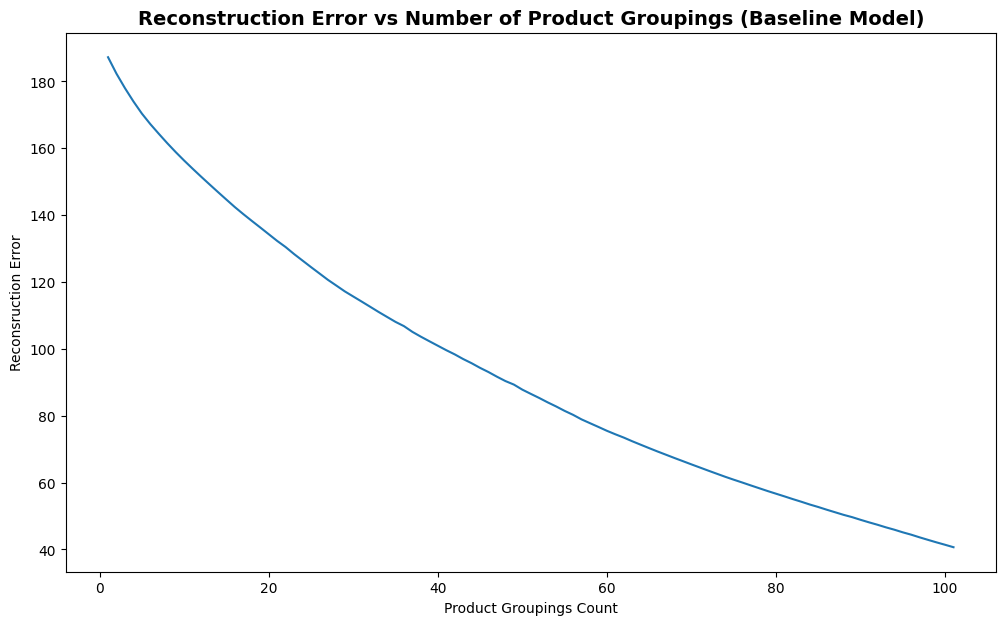

In [28]:
grouping_iteration_display_manager = GroupingIterationDisplayManager(product_grouping_iteration_controller.reconstruction_error_list, 
                                                                     "Reconstruction Error vs Number of Product Groupings (Baseline Model)")
grouping_iteration_display_manager.display()

The reconstruction error of the baseline model never leveled out where the error was minimized. Without any regularization, NMF tries to reconstruct the data and risks overfitting.

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Tuned NMF Model</span>

From the baseline model above, we saw that the reconstruction error never leveled off to a point where adding additional product groupings made any difference. With this next model, I will change some of the parameters to try to allow this to happen (a leveling off of reconstruction error.

<span style="font-size: 14px; font-weight: bold; color: royalblue;">Hyperparameter Tuning Highlights</span>

I want to try a different init method that is better for sparseness. We learned in the **EDA** section that the input matrix V is going to be sparse. I also want to add a little regularization that should help with the complexity of this task. Below is a summary of the changes:

* **nndsvd** will be used for the init method. From the documentation it is noted this is better sparseness.
* **max_iter** is returned to the default value of 200.
* **alpha_W** is given a value of 0.01. This values multiplies the regularization terms for the **W** matrix.
* **alpha_H** is also given a value of 0.01. This multiplies the regularization terms for the **H** matrix.
* **shuffle** is set to True. This works with the **cd** solver to randomize the coordinates. This might help stability of the model fitting.

In [29]:
class TunedNMFModelManager(AbstractNMFManager):
    """
    Tuned NMF model
    """
    def __init__(self, grocery_df):
        super().__init__(grocery_df)

    # Override
    def build_nmf_model(self, num_product_groupings):
        model = NMF(n_components=num_product_groupings,
                    init='nndsvd',
                    solver='cd',
                    beta_loss='frobenius',
                    tol=1e-4,
                    max_iter=200,
                    random_state=SEED_VALUE,
                    alpha_W=0.01,
                    alpha_H=0.01,
                    l1_ratio=0.0,
                    shuffle=True)
        return model

In [30]:
#Early stopping and number of iterations are the same as the previous model.

# Setup the tuned model manager.
model_manager = TunedNMFModelManager(grocery_df)

#Create the product grouping iteration controller
product_grouping_iteration_controller = ProductGroupingIterationController(model_manager, 
                                                                           num_iterations, 
                                                                           early_stopping_controller)

# Find the best value of k for this model (unless it doesn't level off, in which case the model 
# will be using k equal to the max number of iterations).
product_grouping_iteration_controller.fit()

Iteration: 1, reconstruction error: 187.89609635391625
Iteration: 10, reconstruction error: 164.1836956046378
Iteration: 20, reconstruction error: 151.87527681139738
Iteration: 30, reconstruction error: 144.59356635605664
Iteration: 40, reconstruction error: 142.18121421934174


From the output above, it looks like the product grouping iteration manager found a point where the reconstruction error leveled off before it reached the maximum number of product groupings allowed. I will again plot the reconstruction error vs the number of product groupings to see how the fitting went.

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Plotting Reconstruction Error vs Number of Product Groupings (Tuned Model)</span>

With the fewer iterations, this model's reconstruction error leveled out somewhere around iteration 40. I will plot this to see what it looks like.

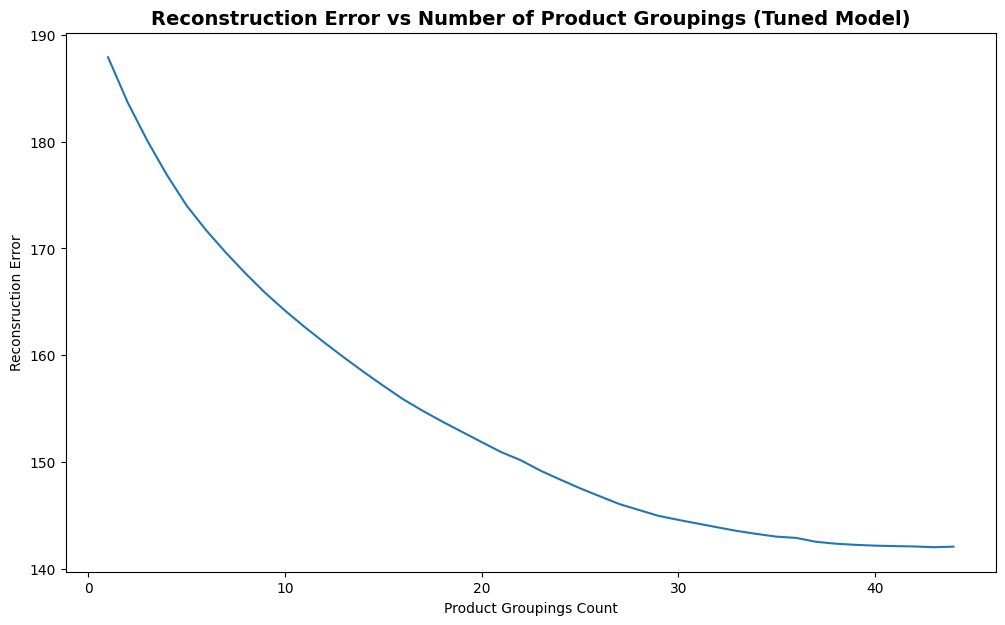

In [31]:
grouping_iteration_display_manager = GroupingIterationDisplayManager(product_grouping_iteration_controller.reconstruction_error_list, 
                                                                     "Reconstruction Error vs Number of Product Groupings (Tuned Model)")
grouping_iteration_display_manager.display()

From the plot it is easy to see that adding product groupings (values of **k**) had little effect on improving the reconstruction error. At this point the early stopping controller informed the product grouping iteration controller to stop running. The best model was kept.

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Visualizing Latent Product Groupings (Tuned Model)</span>

With this **Tuned NMF Model** and the promising reconstruction error plot, it's time to visualize the items in the product groupings to see how we might use this data in a retail setting.

The below class will be used to plot the top 10 items per grouping. The number of products can be increased, but I think for this project, 10 is a good number of items.

In [32]:
class ProductGroupingDisplayManager:
    def __init__(self, best_model_values, num_products_per_grouping, title):
        self.best_model_values = best_model_values
        self.num_products_per_grouping = num_products_per_grouping
        self.title = title
        
    def display(self):
        header_color = '#5072A7'
        row_even_color = '#E6E8FA'
        row_odd_color = '#B0C4DF'
        
        def convert_indices_to_names(top_ranked_product_indices_per_grouping):
            item_names = self.best_model_values.V.columns
            return [[item_names[i] for i in row] for row in top_ranked_product_indices_per_grouping]
            
        # Limit the output to the top products per grouping
        top_ranked_product_per_grouping = convert_indices_to_names(np.argsort(self.best_model_values.H, axis=1)[:, -self.num_products_per_grouping:][:,::-1])

        # Construct the HTML table
        display_html = f"""
                        <div>
                            <div style='font-size: {TITLE_FONT_SIZE * 1.1}px; font-weight: bold; text-align: center; margin-bottom: 10px;'>
                                {self.title}
                            </div>
                    """
        display_html += f"""<table border="1" style='width: 100%; table-layout: auto;'>
                            <tr style="background-color: {header_color}; color: white; border-bottom: 1px solid white;">
                                <th style="white-space: nowrap; text-align: center; border-right: 1px solid white;">Grouping Number</th>
                                <th colspan="{self.num_products_per_grouping}" style="text-align: center;">Items</th>
                            </tr>
                    """
        for i, current_grouping in enumerate(top_ranked_product_per_grouping):
            display_html += f"<tr style='background-color: {row_even_color if i%2==0 else row_odd_color}; border-bottom: 1px solid white;'>"
            display_html += f"<td style='font-weight: bold; border-right: 1px solid white;'>{i+1}</td>"
            for current_item in current_grouping:
                display_html += f"<td style='border-right: 1px solid white;'>{current_item}</td>"
            display_html += "</tr>"

        display_html += "</table> </div>"
        
        display(HTML(display_html))

In [33]:
product_grouping_display_manager = ProductGroupingDisplayManager(product_grouping_iteration_controller.best_model_values,
                                                                 10, 
                                                                 "Latent Product Groupings (Tuned Model)")
product_grouping_display_manager.display()

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Latent Product Grouping Analysis (Tuned Model)</span>

The goal of using NMF in this context was to find products that are likely to be bought together. In interpreting the results, we will think of each of the product groupings above to be items that would be bought together on a typical shopping trip. This can help the retailer better organize the store and possibly increase sales. Let's look at a few of these product groupings:

<u>**Product Grouping 1**</u>

I'm going from right to left in this example. We can see that "citrus fruit", "tropical fruit", and "pip fruit" were included in this product grouping. This makes perfect sense, if you're shopping for fruit, you are likely to buy multiple kinds. Next we see "bottled beer" and "soda" together. Again this makes sense, both are beverages. We have "whole milk" and "yogurt". These would be found in the same section. Then we have "other vegetables", "rolls/buns", and "sausage". This looks like a dinner combination. So what "latent" information could we gather from this grouping of 10 items? It seems that buying items for breakfast and dinner together might be common. What could the retailer do with this information? Perhaps create a "Quick Shop" section where it includes items for breakfast, lunch, and dinner for shoppers that are in a hurry.

<u>**Product Grouping 27**</u>

We see "coffee", "sugar", "misc. beverages", "whole_milk", "chewing gum", "domestic eggs", "frankfurter", "root vegetables", "soda", and "candy". This looks like a much less health grouping with the sugar, chewing gum, soda, and candy all included. A lot of this stuff is found at the register for "impulse" buys so it makes sense. Whole milk, coffee, and domestic eggs seems like a common household purchase. What insight can we gather from this grouping? In this case, it looks like it's showing exactly what we see in grocery stores already. That is, someone goes into the store to buy some basic essentials, and on the way out, picks up some junk food. This is good validation that the grouping makes sense.

<u>**Product Grouping 28**</u>

This grouping has the makings for a typical dinner. "frozen vegetables", "other vegetables", "beef", "sausage", "rolls/buns", and "onions". This looks like it could be a stew. An idea for this would be similar to the product grouping 1, but instead of a section for all meals, this would be tailored to a soup/stew presentation in the store.

<u>**Product Grouping 34**</u>

This grouping looks like a typical work lunch grouping. In this group we have "napkins", "long life bakery product", "frozen meals", "berries", and "dessert" among other things. An idea for this would be to put up a display for a good selection of items for a work lunch that includes healthy options like "berries".

<u>**Product Grouping 36**</u>

This grouping looks like a packed lunch group. We have "white bread", "berries", "grapes", "ham", "fruit vegetable juice", "long life bakery product". An idea would be a "quick lunch" section that includes healthy options (e.g. berries and grapes) along with the traditional sandwich prep.

**Note:**
We see "whole milk" occurring in a lot of the product groupings. From the **EDA** word frequency histograms and word cloud, we saw that "whole milk" was the most frequent word. So this appearing in a lot of the groupings makes sense.

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Added Regularization Tuned NMF Model</span>

The tuned NMF model above seemed to perform well with the regularization changes. I want to take it one step further and add a little more regularization.

With the previous models, the l1_ratio was set to 0.0. This moves all the preference on L2. By increasing this we can introduce L1 penalty as well.

Because this adds additional regularization to an already regularized model, I will reduce the input of the alpha_W and alpha_H values.

<span style="font-size: 14px; font-weight: bold; color: royalblue;">Hyperparameter Tuning Highlights</span>

Below is a summary of the changes:

* **nndsvd** will be used for the init method. From the documentation it is noted this is better sparseness.
* **max_iter** is returned to the default value of 200.
* **alpha_W** is given a value of 0.008. This values multiplies the regularization terms for the **W** matrix.
* **alpha_H** is also given a value of 0.008. This multiplies the regularization terms for the **H** matrix.
* **l1_ratio** is given a modest value of 0.002 for adding L1 influence.

In [34]:
class AddedRegularizationTunedNMFModelManager(AbstractNMFManager):
    """
    Tuned NMF model
    """
    def __init__(self, grocery_df):
        super().__init__(grocery_df)

    # Override
    def build_nmf_model(self, num_product_groupings):
        model = NMF(n_components=num_product_groupings,
                    init='nndsvd',
                    solver='cd',
                    beta_loss='frobenius',
                    tol=1e-4,
                    max_iter=200,
                    random_state=SEED_VALUE,
                    alpha_W=0.008,
                    alpha_H=0.008,
                    l1_ratio=0.002,
                    shuffle=True)
        return model

In [35]:
#Early stopping and number of iterations are the same as the previous model.

# Setup the tuned model manager.
model_manager = AddedRegularizationTunedNMFModelManager(grocery_df)

#Create the product grouping iteration controller
product_grouping_iteration_controller = ProductGroupingIterationController(model_manager, 
                                                                           num_iterations, 
                                                                           early_stopping_controller)

# Find the best value of k for this model (unless it doesn't level off, in which case the model 
# will be using k equal to the max number of iterations).
product_grouping_iteration_controller.fit()

Iteration: 1, reconstruction error: 187.66094232564805
Iteration: 10, reconstruction error: 161.43820448579262
Iteration: 20, reconstruction error: 145.8807517361388
Iteration: 30, reconstruction error: 135.0380508763574
Iteration: 40, reconstruction error: 129.04908752250137
Iteration: 50, reconstruction error: 125.61649755409641
Iteration: 60, reconstruction error: 124.03103270985017


This tuned model with added regularization increased the number of iterations (to include more product groupings) with a lower reconstruction error. It is important to mention that the having a lower score isn't always better, a much better metric is the interpretability of the results.

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Plotting Reconstruction Error vs Number of Product Groupings (Added Regularization Tuned Model)</span>

This model went further with the iterations. Since the number of product groupings increases equally with the iterations, this means there are more product groupings to take a look at.

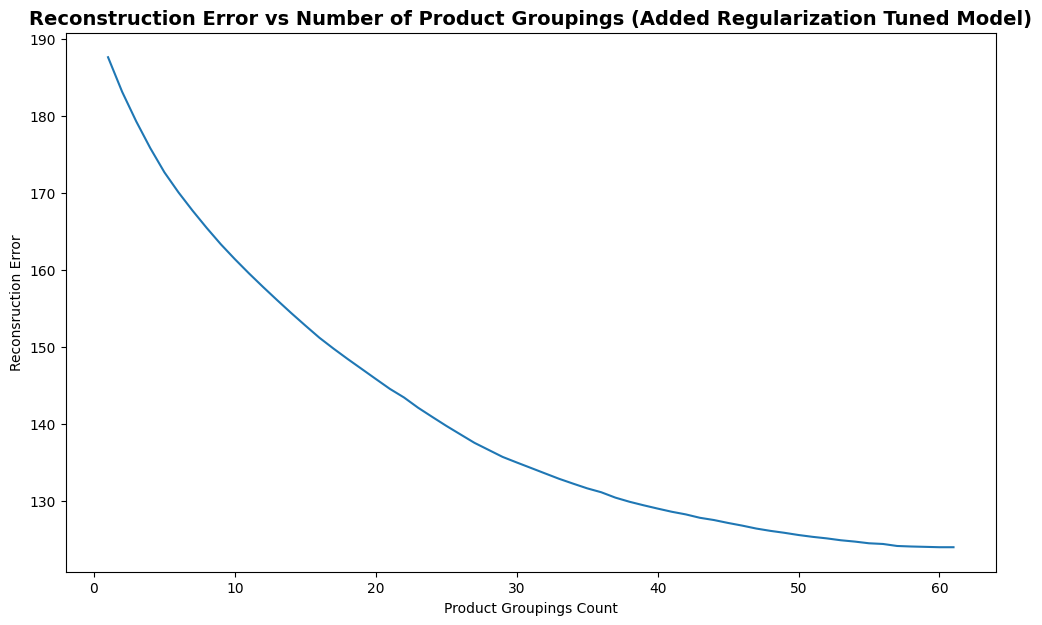

In [36]:
grouping_iteration_display_manager = GroupingIterationDisplayManager(product_grouping_iteration_controller.reconstruction_error_list, 
                                                                     "Reconstruction Error vs Number of Product Groupings (Added Regularization Tuned Model)")
grouping_iteration_display_manager.display()

Like the previous model, this one stabilized at the end. Since it still stopped short of the 100 max iterations, I think the latent product groupings table will have some interesting insight.

In [37]:
product_grouping_display_manager = ProductGroupingDisplayManager(product_grouping_iteration_controller.best_model_values, 
                                                                 10, 
                                                                 "Latent Product Groupings (Added Regularization Tuned Model)")
product_grouping_display_manager.display()

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Latent Product Grouping Analysis (Added Regularization Tuned Model)</span>

Similar to what I did with the latent product groupings analysis for the tuned model, I will do that here. Let's look a a few product grouping examples:

<u>**Product Grouping 39**</u>

In this grouping I see the makings of a typical sporting event watching party. "salty snacks", "canned beer", "red blush wine", "hard cheese", "rolls/buns", "brown bread", "semi-finished bread", "sausage", and "other vegetables". An idea for this would be a display for "Game Day Parties". 

<u>**Product Grouping 40**</u>

This looks like a breakfast grouping. "waffles", "hard cheese", "whole milk", "cream cheese", "domestic eggs", and "oil". The hard cheese could be used to make an omelet. The oil is used to prevent the waffles and eggs from sticking to the pan. An idea would be a breakfast display area for all things to make a breakfast. This looks to have a lunch and dinner sub-section as well with the chicken, root vegetables, and beef. In the previous analysis I suggest the idea for a "Quick Shop" section. This grouping seems to support that idea as well.

<u>**Product Grouping 60**</u>

In this group I see a couple items, "white wine", "soft cheese", "nuts/prunes", that are often consumed together. "newspaper", and "shopping bags". Since shopping bags are usually free, this is likely the reusable type. What I am thinking for this grouping is in the liquor section to include periodicals and special bags just for wine.

**Note:**
Just as in the other latent product analysis section we see "whole milk", "other vegetables", "rolls/buns", etc. pop up quite a bit in the product groupings. Again from the **EDA** word-frequency histogram and word cloud we see that these occur very frequently, so it makes sense for that to carry over here.

## <span style="color: royalblue;">Association Rule Mining</span>

Now I will switch to the second part of this project, using association rule mining to uncover which products are bought together. From the grocery transaction data, the association rules will predict the occurrence of an item based on the occurrences of other items in the basket. This is a complementary approach to using the **NMF** approach that was just done. This approach was not taught in class, and I am exited to try it out. Like **NMF**, it is an unsupervised learning technique and commonly used in retail to identify relationships between products.

For this unsupervised learning technique, I will be using the **Apriori** algorithm.

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Apriori Algorithm Overview</span>

The **Apriori** algorithm is used to find frequent itemsets and generating association rules. An itemset in this context is a combination of products that are frequently bought together.

It first analyzes the dataset to identify the frequency of individual items, not unlike the word-frequency histogram. Doing this a threshold is set that will determine if an itemset will be labeled as frequent. This is known as a *minimum support threshold*. Using the single component items it then moves on to items with 2 components finding those which are frequent. It continues to do this with larger and larger item component clusters until no more frequent item groups can be found. It then prunes the infrequent item groups. The algorithm used will remove infrequent itemsets and all of that item set's supersets. Once this is done, the algorithm will generate *association rules* that show how items relate to each other.

There are a number of metrics associated with the Apriori algorithm. These include **support**, **confidence**, and **lift**. Support measures how often an itemset appears in the dataset. Confidence refers to the probability a given item is purchased when another item (or group of items) is purchased. Lift is how likely multiple items are to be purchased together rather than purchased individually.

I will be using the **mlxtend apriori** Python library for this portion of the project (link in the references).

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Preparing the Data</span>

The Apriori library works with one-hot encoded data similar to the NMF library. The only change needed is it should be converted to type **bool**. So the Apriori manager can use the same DataCreator class as the NMF managers did.

In [38]:
class AbstractAprioriManager(ABC):
        """
        Handles the common tasks for creating a frequent itemset dataset.
        """
        def __init__(self, grocery_df):
            self.data_creator = DataCreator(grocery_df)

        @abstractmethod
        def get_min_support(self):
            #override in subclass
            pass

        def get_frequent_itemsets(self):
            # Need to convert it to type bool to silence a warning from the apriori library
            baskets = self.data_creator.create_one_hot_matrix().astype(bool)

            # Use the Apriori algorithm to get the frequent itemsets
            frequent_itemsets = apriori(baskets, min_support=self.get_min_support(), use_colnames=True)
            return frequent_itemsets, baskets

In [39]:
class AbstractAssociationRulesManager(ABC):
    """
    Manages the creation and handling of association rules based on the frequent itemset dataset.
    """
    def __init__(self, frequent_itemset, baskets):
        self.frequent_itemsets = frequent_itemset
        self.baskets = baskets

    @abstractmethod
    def get_metric(self):
        # Override in subclass
        pass

    @abstractmethod
    def get_min_threshold(self):
        # Override in subclass
        pass

    def process_rules(self, confidence_percent):
        # Create the association rules
        rules = association_rules(self.frequent_itemsets, metric=self.get_metric(), min_threshold=self.get_min_threshold())

        # Create a column 'num_transaction' to see how many times the combination of the antecedents and consequents occured
        rules['num_transactions'] = rules['support'] * self.baskets.shape[0]

        # Filter based on the confidence percent. Generally we want a high confidence
        return rules[(rules['confidence'] >= confidence_percent)]

In [40]:
class LiftBasedAssociationRulesProcessor(AbstractAssociationRulesManager):
    """
    Creates the rules based on the "lift" metric.
    """
    def __init__(self, frequent_itemset, baskets):
        super().__init__(frequent_itemset, baskets)

    # Override
    def get_metric(self):
        return 'lift'

    # Override
    def get_min_threshold(self):
        return 1

In [41]:
class AssociationRuleDisplayManager:
    def __init__(self, association_rules, title):
        self.association_rules = association_rules
        self.title = title

    def __sort_and_reorder_columns(self):
        sorted_rules = self.association_rules.sort_values(by=['confidence', 'lift', 'num_transactions'], ascending=[False, False, False])
        
        front_columns = ['antecedents', 'consequents', 'confidence', 'lift', 'support', 'num_transactions']
        updated_order = front_columns + [col for col in sorted_rules.columns if col not in front_columns]
        
        return sorted_rules[updated_order]
        
    def display(self):
        header_color = '#285124'#006A4E
        row_even_color = '#D8E4BC'
        row_odd_color = '#B0C9B8'

        def adjust_value(name, value):
            if name == 'antecedents' or name == 'consequents':
                value = ', '.join(value)
            elif name == 'num_transactions':
                value = round(value)
            else:
                value = f"{value:.5f}"
                
            return value

        updated_association_rules = self.__sort_and_reorder_columns()
        
        display_html = f"""
            <div>
                <div style='font-size: {TITLE_FONT_SIZE * 1.1}px; font-weight: bold; text-align: center; margin-bottom: 10px;'>
                    {self.title}
                </div>
                <table style='width: 100%; table-layout: auto; border-collapse: collapse;'>
                    <tr style='background-color: {header_color}; color: white; border-bottom: 1px solid white;'>
                    <th style='white-space: nowrap; text-align: center; border-right: 1px solid white;'/>
        """
        for column_name in updated_association_rules.columns:
            display_html += f"<th style='white-space: nowrap; text-align: center; border-right: 1px solid white;'>{column_name}</th>"

        display_html += "</tr>"
        
        for i, (_, current_row) in enumerate(updated_association_rules.iterrows()):
            display_html += f"""
                            <tr style='background-color: {row_even_color if i%2==0 else row_odd_color}; border-bottom: 1px solid white;'>
                            <td style='font-weight: bold; border-right: 1px solid white;'>{i + 1}</td>
                            """
            for column_name, column_value in current_row.items():
                display_html += f"<td style='border-right: 1px solid white;'>{adjust_value(column_name, column_value)}</td>"
            display_html += f"</tr>"

        display_html += "</table></div>"
        display(HTML(display_html))

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Narrow Apriori Filter</span>

With the Apriori algorithm, we can set the min support level to filter out less prominent transactions. A transaction in this case includes the combination of the *antecedents* and *consequents*, or more generally, the independent and dependent items. Support refers to how often that combination occurs in all the transactions.

With a narrower filter we will get more prominent transactions, and that, of course, means we will get less transactions reported. With Apriori this is known as the *itemsets*.

<span style="font-size: 14px; font-weight: bold; color: royalblue;">Hyperparameter Tuning Highlights</span>

For this, we are only going to control the *min_supprt* as discussed above. The intention here is to get more prominent transactions from the "baskets".

In [42]:
class NarrowAprioriManager(AbstractAprioriManager):
    """
    A moderate min_support to capture more frequent product combinations
    """
    def __init__(self, grocery_df):
        super().__init__(grocery_df)

    # Override
    def get_min_support(self):
        return .0005

In [43]:
# Use a narrow "filter" to get more 
narrow_apriori_manager = NarrowAprioriManager(grocery_df)
frequent_itemsets, baskets = narrow_apriori_manager.get_frequent_itemsets()

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Narrow Apriori Association Rules</span>

Using the narrow apriori filter we obtained the a list of itemsets. Now we have to process this itemsets into association rules. These association rules are what we are interested in from using the Apriori algorithm.

The association rules will get us the *antecedents* and *consequents*. Simply stating it will show us "people that bought X, tend to also buy Y". We will also get some valuable metrics like the confidence and "lift" of that rule as well as how often that combination occurs in the transaction. In the superclass of the LiftBasedAssociationRulesProcessor, the support is translated into an actual number of transactions to make it easier to interpret. With the rules processor we limit the lift value to be at least one. A value greater than one shows a positive correlation between the *antecedents* and *consequents*. 

Because the number of itemsets will be lower with a narrow filter, I will include rules that will have a 20% or greater confidence.

In [44]:
# Create a lift-based association rules processor
lift_based_association_rules_processor = LiftBasedAssociationRulesProcessor(frequent_itemsets, baskets)
processed_rules = lift_based_association_rules_processor.process_rules(0.20)

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Displaying Narrow Apriori Association Rules</span>

Now that we obtained the association rules, I will display them. I created the **AssociationRuleDisplayManager** class to do this. It will sort the rules based on *confidence*, *lift*, and *num_transactions*. It will then reorder the rules so we can see the information we are most interested up front.

In [45]:
# Display the processed rules in a table
association_rule_display_manager = AssociationRuleDisplayManager(processed_rules, "Narrow Apriori Association Rules")
association_rule_display_manager.display()

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Analysis and Discussion of Narrow Apriori Association Rules</span>

In the association rules processor class I filtered the rules so that only those with a confidence of 20% or higher are included. This is a relatively low confidence level but can still give us insight into sales patterns. Note the **lift** values are all above 1, indicating a positive correlation between the independent *antecedents* and the dependent *consequents*.

Let's look at a couple rows in detail that show an interesting relationship:

<u>**Row 17**</u>

Here we see that a yogurt is 2.4 times more likely to be purchased when whipped sour cream and rolls/buns are also purchased. This has a low confidence and only appeared in 9 of the transactions however.

<u>**Row 18**</u>

This rule shows that rolls/buns are 1.9 times more likely to be purchased when yogurt and whipped sour cream are also purchased. This supports the first rule.

<u>**Analysis**</u>

What might a retailer do with this data? They might want to create promtions with items listed in the first two columns. Or more those items closer together.

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Wide Apriori Filter</span>

Now I will create an Apriori filter that captures more transactions. Transactions that might be more rare but still give retailers some valuable insight into purchasing patterns.

<span style="font-size: 14px; font-weight: bold; color: royalblue;">Hyperparameter Tuning Highlights</span>

Again for this filter we are only going to control the *min_supprt* parameter. The intention here is to include more transactions into the itemsets.

In [46]:
class WideAprioriManager(AbstractAprioriManager):
    """
    A low min_support to capture more infrequent product combinations
    """
    def __init__(self, grocery_df):
        super().__init__(grocery_df)

    # Override
    def get_min_support(self):
        return .0002

In [47]:
# Cast a wide net to get more itemsets
narrow_apriori_manager = WideAprioriManager(grocery_df)
frequent_itemsets, baskets = narrow_apriori_manager.get_frequent_itemsets()

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Wide Apriori Association Rules</span>

Again, using the wide apriori filter, we obtained the a list of itemsets. Now we have to process this itemsets into association rules.

As mentioned above, the association rules will get us the *antecedents* and *consequents*. Because the number of itemsets will be greater with the wide filter, I will increase the confidence to 74% to only show those rules that are highly confident.

In [48]:
# Create a lift-based association rules processor
lift_based_association_rules_processor = LiftBasedAssociationRulesProcessor(frequent_itemsets, baskets)
processed_rules = lift_based_association_rules_processor.process_rules(0.74)

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Displaying Wide Apriori Association Rules</span>

Again I will use the created **AssociationRuleDisplayManager** class to do display the association rules just obtained.

In [49]:
# Display the processed rules in a table
association_rule_display_manager = AssociationRuleDisplayManager(processed_rules, "Wide Apriori Association Rules")
association_rule_display_manager.display()

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Analysis and Discussion of Wide Apriori Association Rules</span>

In the association rules processor class I filtered the rules so that only those with a confidence of 74% or higher are included. This is a strong confidence level. With this however, we will get transactions that are less prominent. Again this can still give retailers valuable insight as the number of transactions are dependent on the dataset and a larger dataset might yield similar patterns.

Let's look at a few rows in detail:

<u>**Row 1**</u>

Here we see that specialty chocolate is 63 times more likely to be purchased when cream cheese, citrus fruit, and chicken are also purchased. The confidence is extremely high as well. However discretion must be taken here as this combination only occurred 3 times in the itemsets.

<u>**Row 2**</u>

Here we see that hamburger meat is 46 times more likely to be purchased when frankfurters, soda, and root vegetables are purchased. A barbeque perhaps? Again the confidence is very high but the number of transactions are low.

<u>**Row 26**</u>

Moving down the list we find that whole milk is 5 times to be more likely to be purchased when pastry, soda, and "other" vegetables are also purchased. The confidence is also high at 83% and the number of transactions are a little higher at 5 (still low though).

<u>**Analysis**</u>

What can a retailer do with this information? Even though the number of transactions are low, it can still show possible product associations and a larger dataset might support this finding. In the second example we saw a possible "barbeque" itemset. The retailer could create a barbeque display to increase those sales. We saw in the last example that whole milk was the consequent item. Whole milk happens *a lot*. We saw this when using **NMF** as well as in the **EDA** section. All three of these analysis tools are showing consistent results and this is always good. Especially with unsupervised learning when we don't have labels to double check things. This means that interpretation is very important.


## <span style="color: royalblue;">Results Summary (NMF and Apriori)</span>

In the latent product groupings portion of this project, we saw product groupings that could be used by retailers to make store layouts more convenient for shoppers and possibly drive sales for the hidden (latent) product connections. We went through a new model iterations with various hyperparameters tuned to see how this affected our results. It was discovered that regularization had a positive effect on the results.

With association rule mining, we saw that the Apriori algorithm was able to find itemsets that could be used to create association rules. We went through a couple iterations altering the *min_algorithm* to see how it affects the rules being generated. Analyzing a few of the rules we discovered ways that retailers can see how item purchases might be related. From this information it can help retailers decide how to display items.

The complementary approaches of latent product groupings and association rule mining can aid retailers in making decisions about item display, promotion, and even ordering.

## <span style="color: royalblue;">Summary, Discussion, and Conclusion</span>

I started out with getting a feel for the dataset that will be used in this project. We took a glimpse of the data, got the datatypes, the size, and unique counts. We saw there was no missing data and the dataset is a decent size for an unsupervised learning task. We saw that the the items in the dataset are a relatively generic description.

Next I moved onto **exploratory data analysis (EDA) and data cleaning**. In this section I started out renaming the columns. While this wasn't necessary, it did help with use being named in a more common way. I then changed the data types of the date and item fields. Pandas recommends that text data be stored as StringDtype, so that is what I used. The date field was converted to a date type. 

A set of duplicate rows were discovered and removed. While in some cases this duplicate data might be useful, for this project it was not and had the potential to interfere with the model use and analysis.

I trimmed the item text as well as made sure it was all lowercase to keep in consistent.

Using a word-frequency histogram to discover the most frequent words it was discovered that the items with more than one word were being split apart. From this, I replaced characters that caused this and saw how this altered the word-frequency histogram.

Because of space issues, the word-frequency histograms were limited in the number of items included. Because of this, I also used a word cloud plot from all the items. I think this was definitely a complementary approach with the histograms as it was very easy to see which were the dominant items in the dataset.

A co-occurrence heatmap was created to visualize which items might be purchased together. This was a useful complimentary approach to the later results.

Using the information from the data analysis, EDA, and data cleanup sections was helpful in the **NMF** model creation and **Apriori** algorithm configuration.

Next I moved on the model-building portion of the project. That is, the **latent product grouping**. In this section I used the **non-negative matrix factorization (NMF)** that we learned about in the class. In this section I went through several iterations, each with an alteration to the hyperparameters. I noted in each iteration what the changes were intended to do. The first iteration was meant to be a baseline of sorts to see how the model will perform with basically the default settings on the NMF model (I did increase the default number of iterations to ensure all values of k (product groupings) would converge. It was discovered that without regularization the model's reconstruction error over the increasing number of product groupings never leveled out suggesting the model was working hard to replicate the original data matrix from the **W** and **H** matrices, which is a sign that the data was being overfit. In the next iterations of the **NMF** model tuning I added regularization. Doing this, the reconstruction error quickly leveled off which suggested further increases in the number of product groupings would not lead to improvements. Using a custom *early stopping controller* this was monitored and the analysis was stopped when significant progress slowed.

What did we learn from the latent product groupings? I wen through several examples discussing the potential relationships between the products and how a retailer could use that information to plan the layout of the store and potentially increase sales. Details on this are in the above **Latent Product Grouping Analysis** sections, so I won't duplicate that here.

Moving onto the **association rule mining** portion of the project I used another unsupervised learning technique that was not covered in the class. This was definitely a complimentary approach to the problem and as we saw gave some possibly valuable insight into the how retailers can use transaction data to adjust store layouts and also increase sales. With this approach the **Apriori** algorithm was used to construct itemsets of various combinations of products. These itemsets where then used to construct the association rules that we were after. Using various metrics like **confidence** and **lift** we were able to analyze the results.

Similar to the latent product groupings section, I went through a couple iterations to see how altering the *min_support* parameter can affect the itemsets and the association rules. We saw that a more narrow setting would get less association rules with lower confidence and lift values (although the number of transactions were higher) and a more broad setting for *min_support* would yield a larger number of association rules with higher confidence and lift values (but a lower number of overall transactions). So we saw the tradeoff between the settings.

What did we learn from the association rule mining? We saw how a customer might tend to purchase one item given the purchase of another item (or group of items). Complimentary to the latent product groupings results, this can help the retailer better plan the store layout, create displays, or even offer certain promotions.

Together with the **EDA** section, the **latent product groupings** and **association rule mining** of the data can give valuable insight into the how unlabeled transaction data can be used in positive ways in a retail setting. We saw which items were prominent in the **EDA** section and that was consistent with what we saw in the later sections.

<span style="font-size: 14px; font-weight: bold; color: royalblue;">What worked well?</span>
* The data analysis, EDA, and data cleanup worked well in discovering important metrics on the data and what needed to be addressed before model building (latent product groupings) and association rule mining.
* Getting practice with regularization and working with smaller amounts of data.
* The various plots helped visualize the data and how changes in the model affected the outcome.
* The complimentary approach of latent product groupings and association rule mining.

<span style="font-size: 14px; font-weight: bold; color: royalblue;">What could be improved?</span>
* Overall I am happy with the results. I found it very interesting on how these approaches could be used. But I think that a larger dataset might be needed to really see the impact of these two methods. 
* I think the amount of model changes with parameter tuning showed how much tuning can affect the outcome. Further refinements could improve the results even further.

## <span style="color: royalblue;">Resources</span>
* https://pandas.pydata.org/pandas-docs/stable/user_guide/text.html
* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html
* https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html
* https://medium.com/@randeniyamalitha08/performing-a-market-basket-analysis-using-the-apriori-algorithm-python-8a11742253dd
* https://www.geeksforgeeks.org/what-is-the-meaning-of-latent-features/
* https://marketmathandmodels.com/2024/11/19/unsupervised-machine-learning-non-negative-matrix-factorisation-nmf/
* https://medium.com/voice-tech-podcast/topic-modelling-using-nmf-2f510d962b6e
* https://mljourney.com/understanding-non-negative-matrix-factorization-nmf/
* https://www.geeksforgeeks.org/non-negative-matrix-factorization/
* https://www.geeksforgeeks.org/unsupervised-machine-learning-examples/
* https://medium.com/codenx/product-recommendation-system-using-matrix-factorization-in-ml-net-003f4370e3ec
* https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
* https://arxiv.org/abs/2010.01935
* https://www.markovml.com/blog/latent-dirichlet-allocation
* https://www.geeksforgeeks.org/market-basket-analysis-in-data-mining/
* https://www.geeksforgeeks.org/association-rule/
* https://www.geeksforgeeks.org/apriori-algorithm/
* https://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/
* https://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/
* https://www.geeksforgeeks.org/frequent-item-set-in-data-set-association-rule-mining/